# 讀取姿勢特徵

In [148]:
import os
import numpy as np
import pandas as pd

# 指定資料夾路徑
folder_path = 'data/Yu_Darvish_FF_videos_4S/features'

# 取得所有 .npy 檔案的完整路徑
npy_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.npy')]

# 讀取所有 .npy 檔案並儲存在一個 list 中
all_features = [np.load(f).T for f in npy_files]

# 可選：顯示第一筆資料的形狀來確認內容
print(f"共有 {len(all_features)} 筆資料")
print("第一筆資料形狀：", all_features[0].shape)


共有 200 筆資料
第一筆資料形狀： (60, 4)


# 讀取標籤

In [149]:
csv_feat = pd.read_csv('data/Downloads/Yu_Darvish_FF_with_videos.csv')
print(f"csv_feat shape: {csv_feat.shape}")
display(csv_feat.head())

csv_feat shape: (759, 119)


,video_filename,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,attack_angle,attack_direction,swing_path_tilt,intercept_ball_minus_batter_pos_x_inches,intercept_ball_minus_batter_pos_y_inches
0,pitch_0001.mp4,FF,2022/9/30,91.3,-2.31,5.34,"Darvish, Yu",543281,506433,NaN,...,1.0,1.27,0.37,0.37,38.7,NaN,NaN,NaN,NaN,NaN
1,pitch_0002.mp4,FF,2022/9/30,91.9,-2.02,5.54,"Darvish, Yu",543281,506433,NaN,...,1.0,1.28,0.51,0.51,44.1,NaN,NaN,NaN,NaN,NaN
2,pitch_0003.mp4,FF,2022/9/30,94.2,-2.13,5.39,"Darvish, Yu",656024,506433,field_out,...,2.0,1.09,0.42,0.42,40.3,NaN,NaN,NaN,NaN,NaN
3,pitch_0004.mp4,FF,2022/9/30,93.7,-2.54,5.25,"Darvish, Yu",660162,506433,double,...,1.0,1.19,0.84,-0.84,32.1,NaN,NaN,NaN,NaN,NaN
4,pitch_0005.mp4,FF,2022/9/30,92.3,-2.56,5.26,"Darvish, Yu",657757,506433,NaN,...,1.0,1.22,0.86,-0.86,32.4,NaN,NaN,NaN,NaN,NaN


# 定義X,y

In [150]:
X = np.array(all_features)
y = csv_feat['description'][:200]
print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (200, 60, 4), y shape: (200,)


# 類別分佈（Label distribution）希望類別平衡

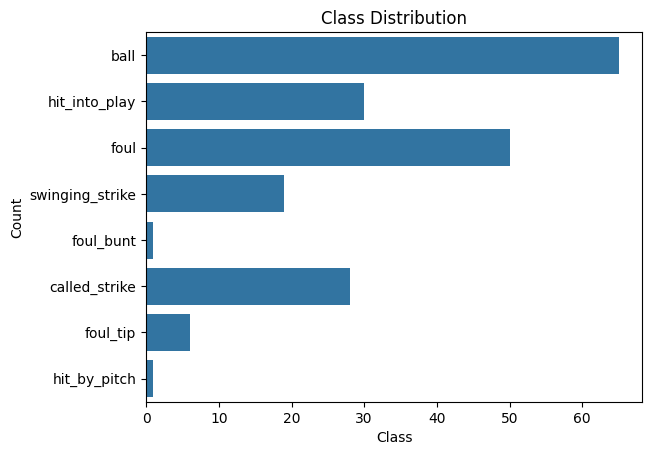

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(y)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


# 特徵的範圍與分佈

In [152]:
import numpy as np
X_reshaped = X.reshape(-1, 4)  # 合併所有樣本與時間

for i in range(4):
    print(f"features {i} → min: {X_reshaped[:, i].min():.2f}, max: {X_reshaped[:, i].max():.2f}, mean: {X_reshaped[:, i].mean():.2f}, std: {X_reshaped[:, i].std():.2f}")


features 0 → min: 0.52, max: 81.27, mean: 24.54, std: 10.91
features 1 → min: 0.62, max: 1.00, mean: 0.97, std: 0.04
features 2 → min: 6.50, max: 178.89, mean: 133.25, std: 30.26
features 3 → min: 0.00, max: 0.28, mean: 0.10, std: 0.03


# 訓練測試切分

In [153]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# X 做標準化轉換 

In [154]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# y 做label encoding

In [155]:
from sklearn.preprocessing import LabelEncoder

# 初始化 LabelEncoder
le = LabelEncoder()

# 對 y_train 進行 fit 和 transform
y_train_encoded = le.fit_transform(y_train)

# 對 y_test 只做 transform（使用相同的編碼規則）
y_test_encoded = le.transform(y_test)


# 特徵的箱型圖檢查

# 希望不要太多離群值

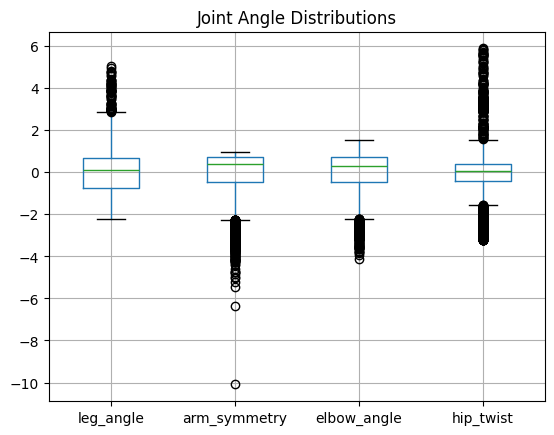

In [156]:
import pandas as pd
df = pd.DataFrame(X_train.reshape(-1, 4), columns=["leg_angle", "arm_symmetry", "elbow_angle", "hip_twist"])
df.boxplot()
plt.title("Joint Angle Distributions")
plt.show()


# 單一樣本或幾筆樣本的角度變化趨勢（時間序列可視化）

# 希望一樣的特徵 在不同樣本 都有類似趨勢

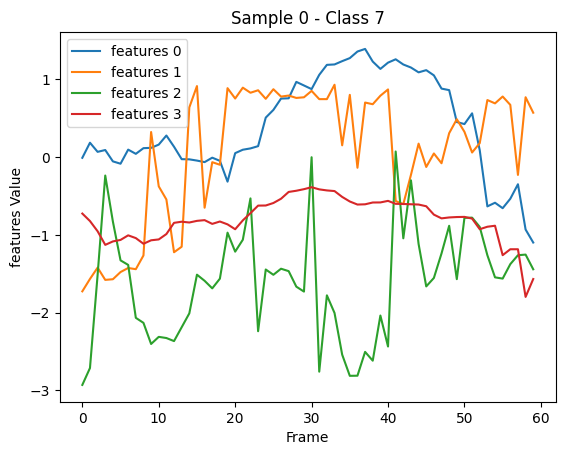

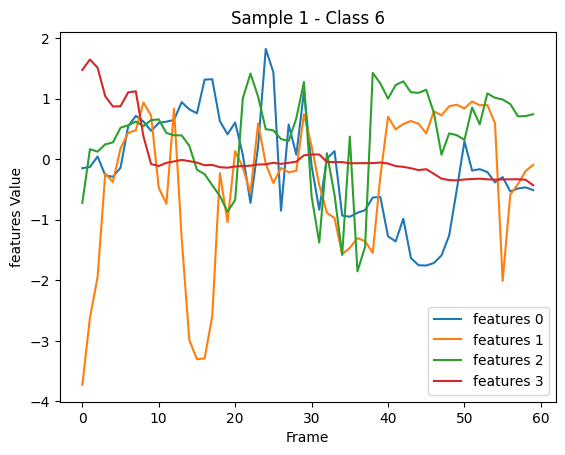

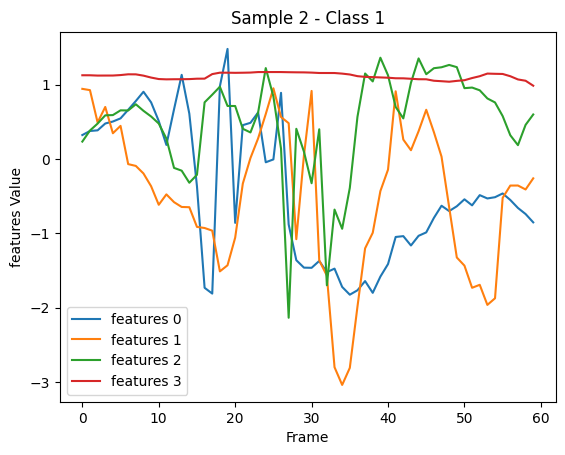

In [157]:
for sample_idx in [0,1,2]:
    for i in range(4):
        plt.plot(X_train[sample_idx, :, i], label=f"features {i}")
    plt.title(f"Sample {sample_idx} - Class {y_train_encoded[sample_idx]}")
    plt.xlabel("Frame")
    plt.ylabel("features Value")
    plt.legend()
    plt.show()


# 根據類別分組樣本 看每組樣本的平均變化 希望區分的開

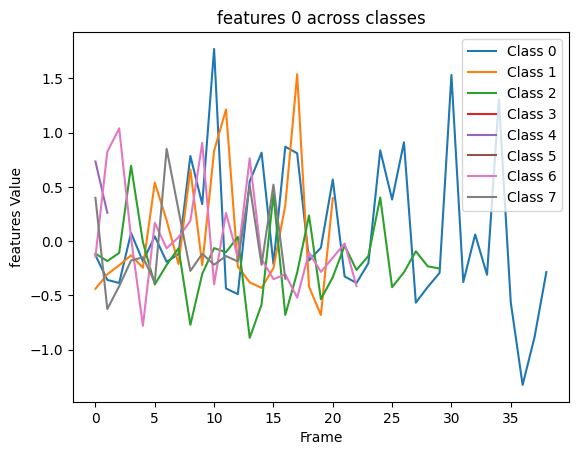

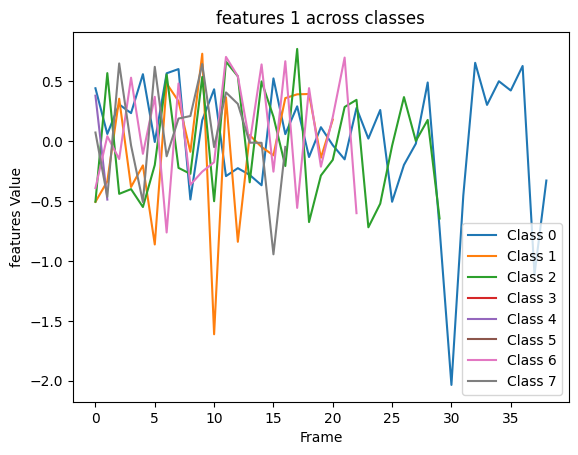

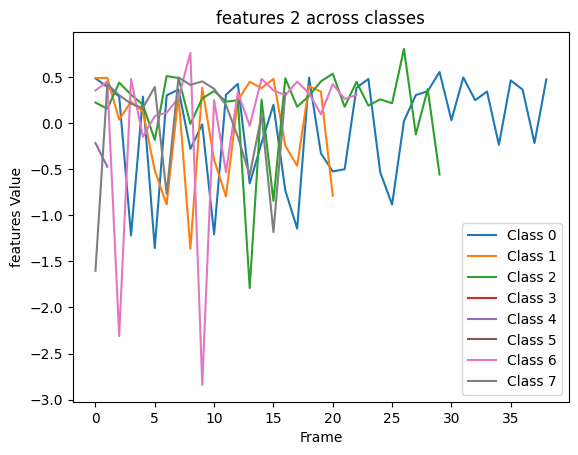

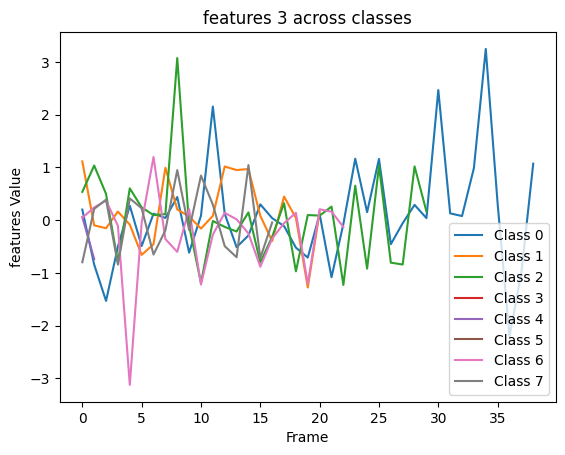

In [158]:
for feature_idx in range(4):
    for c in np.unique(y_train_encoded):
        idx = np.where(y_train_encoded == c)[0]#每類挑多組樣本
        plt.plot(X_train[idx, :, feature_idx].mean(axis=1), label=f"Class {c}")  # 每類多組樣本取平均
    plt.title(f"features {feature_idx} across classes")
    plt.xlabel("Frame")
    plt.ylabel("features Value")
    plt.legend()
    plt.show()


# 降維觀察 希望資料區分的開

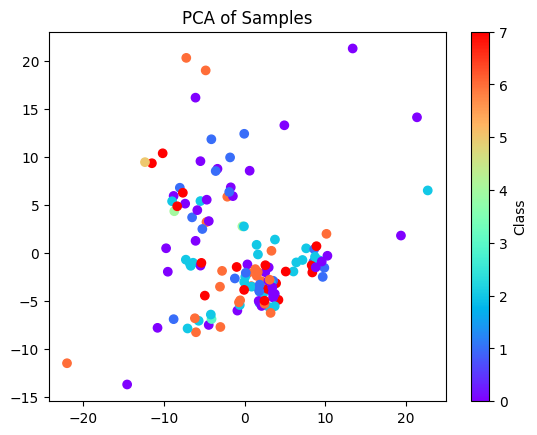

In [159]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

X_flat = X_train.reshape(X_train.shape[0], -1)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_encoded, cmap='rainbow')
plt.title("PCA of Samples")
plt.colorbar(label='Class')
plt.show()

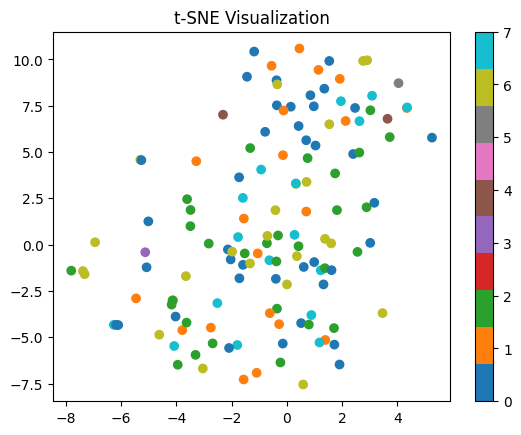

In [160]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_flat = X_train.reshape(X_train.shape[0], -1)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_flat)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train_encoded, cmap='tab10')
plt.title("t-SNE Visualization")
plt.colorbar()
plt.show()


# 根據Y分組 觀察 希望看到的是組間差異大 組內差異小 F= MSwithin/MSbetween

# 考量單禎的情況

In [161]:
mid_frame_idx = X.shape[1]//2
print(f"中間幀索引: {mid_frame_idx}")
import numpy as np
from scipy.stats import f_oneway

for col in range(4):  # 假設你只針對前4個特徵做
    groups = [X[y == label, mid_frame_idx, col].reshape(-1) for label in np.unique(y)]  # flatten 成一維
    f_stat, p_val = f_oneway(*groups)
    print(f'特徵:{col} -> F={f_stat:.4f}, p={p_val:.4f}')


中間幀索引: 30
特徵:0 -> F=0.9322, p=0.4827
特徵:1 -> F=0.2472, p=0.9726
特徵:2 -> F=0.5969, p=0.7580
特徵:3 -> F=0.8617, p=0.5379


# 考量多禎的情況 取平均 希望F_STAT超過1 p_val小於0.05

In [162]:
import numpy as np
from scipy.stats import f_oneway
f_stat_dict ={}
p_val_dict = {}
for frame_idx in range(60):  # 對每一幀進行分析
    for col in range(4):  # 假設你只針對前4個特徵做
        groups = [X[y == label, mid_frame_idx, col].reshape(-1) for label in np.unique(y)]  # flatten 成一維
        f_stat, p_val = f_oneway(*groups)
        try:
            f_stat_dict[col] += f_stat
            p_val_dict[col] += p_val
        except:
            f_stat_dict[col] = f_stat
            p_val_dict[col] = p_val
f_stat_dict = {k: v / 60 for k, v in f_stat_dict.items()}
p_val_dict = {k: v / 60 for k, v in p_val_dict.items()}
print('各特徵的f_stat:', f_stat_dict)
print('各特徵的p_val:', p_val_dict)


各特徵的f_stat: {0: 0.9321955700436833, 1: 0.24722580342151435, 2: 0.5969294246883974, 3: 0.8616699763761472}
各特徵的p_val: {0: 0.48273081405962437, 1: 0.9725914742873257, 2: 0.7579801157579176, 3: 0.5379153280708103}


# 建模Temporal Convolutional Network，時序卷積網路

In [163]:
#我有一個數據shape如下 以X來說是(batch,frame,feature) y來說是(batch,)，其中batch是樣本數，frame是時間幀數，feature是特徵數。
#Y的數值為整數每個整數代表一個"類別"
#我想將以下數據丟到一個Temporal Convolutional Network，時序卷積網路做訓練
#在訓練過程紀錄訓練準確度 測試準確度 訓練損失 測試損失
#並且在訓練結束後將訓練準確度 測試準確度 訓練損失 測試損失繪製圖表出來
#最後給出分類報告以及混淆矩陣 
X_train.shape, X_test.shape, y_train_encoded.shape, y_test_encoded.shape
((134, 60, 4), (66, 60, 4), (134,), (66,))

((134, 60, 4), (66, 60, 4), (134,), (66,))

In [164]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size] if self.chomp_size > 0 else x

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride,
                               padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride,
                               padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.chomp2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        # shape now should match
        return self.relu(out + res)


class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                                        dilation=dilation_size, padding=(kernel_size - 1) * dilation_size,
                                        dropout=dropout))
        self.network = nn.Sequential(*layers)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        x = x.transpose(1, 2)  # [batch, features, time]
        y = self.network(x)
        return self.linear(y[:, :, -1])  # 只取最後時間步的輸出


In [165]:
# 假設你已經有如下 NumPy 數據
# X_train.shape = (134, 60, 4)
# X_test.shape = (66, 60, 4)
# y_train_encoded.shape = (134,)
# y_test_encoded.shape = (66,)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [166]:
def train_model(model, train_loader, test_loader, criterion, optimizer, epochs=100):
    train_loss_list, test_loss_list = [], []
    train_acc_list, test_acc_list = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, train_loss = 0, 0, 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
        train_acc = correct / total
        train_loss /= len(train_loader)

        # Evaluate
        model.eval()
        correct, total, test_loss = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()
        test_acc = correct / total
        test_loss /= len(test_loader)

        # Record
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f} - Test Acc: {test_acc:.4f}")

    return train_loss_list, test_loss_list, train_acc_list, test_acc_list


Epoch 1/100 - Train Acc: 0.1791 - Test Acc: 0.2727
Epoch 2/100 - Train Acc: 0.2015 - Test Acc: 0.3939
Epoch 3/100 - Train Acc: 0.3060 - Test Acc: 0.3939
Epoch 4/100 - Train Acc: 0.2388 - Test Acc: 0.3939
Epoch 5/100 - Train Acc: 0.2985 - Test Acc: 0.2424
Epoch 6/100 - Train Acc: 0.2687 - Test Acc: 0.3788
Epoch 7/100 - Train Acc: 0.3284 - Test Acc: 0.3939
Epoch 8/100 - Train Acc: 0.2910 - Test Acc: 0.3333
Epoch 9/100 - Train Acc: 0.3060 - Test Acc: 0.1515
Epoch 10/100 - Train Acc: 0.3806 - Test Acc: 0.3182
Epoch 11/100 - Train Acc: 0.3284 - Test Acc: 0.3182
Epoch 12/100 - Train Acc: 0.3657 - Test Acc: 0.3030
Epoch 13/100 - Train Acc: 0.3433 - Test Acc: 0.3182
Epoch 14/100 - Train Acc: 0.3955 - Test Acc: 0.2121
Epoch 15/100 - Train Acc: 0.3806 - Test Acc: 0.2576
Epoch 16/100 - Train Acc: 0.4030 - Test Acc: 0.3333
Epoch 17/100 - Train Acc: 0.3881 - Test Acc: 0.2424
Epoch 18/100 - Train Acc: 0.4030 - Test Acc: 0.2576
Epoch 19/100 - Train Acc: 0.3881 - Test Acc: 0.2576
Epoch 20/100 - Train 

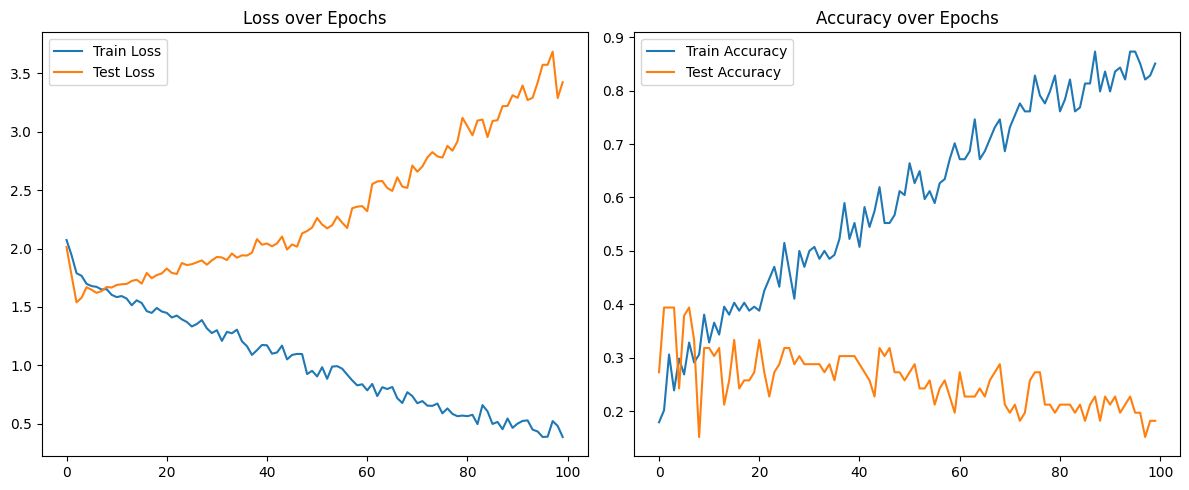

In [167]:
num_classes = len(np.unique(y_train_encoded))
model = TCN(input_size=4, output_size=num_classes, num_channels=[16, 32, 64], kernel_size=3, dropout=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss, test_loss, train_acc, test_acc = train_model(model, train_loader, test_loader, criterion, optimizer)

# 繪圖
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.tight_layout()
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.27      0.30        26
           1       0.00      0.00      0.00         7
           2       0.21      0.20      0.21        20
           4       0.00      0.00      0.00         4
           6       0.09      0.14      0.11         7
           7       0.00      0.00      0.00         2

    accuracy                           0.18        66
   macro avg       0.11      0.10      0.10        66
weighted avg       0.20      0.18      0.19        66

Confusion Matrix:


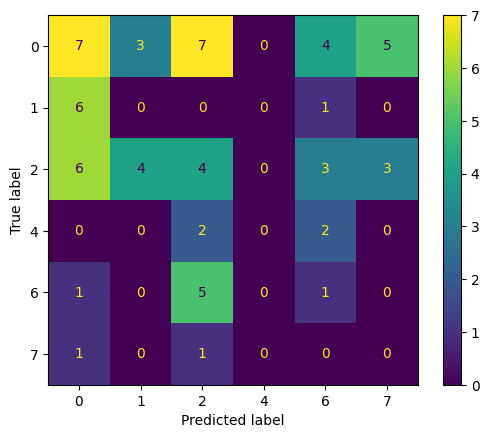

In [168]:
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

model.eval()
with torch.no_grad():
    all_preds = []
    all_labels = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(all_labels, all_preds)
plt.show()


In [169]:
le.classes_

array(['ball', 'called_strike', 'foul', 'foul_bunt', 'foul_tip',
       'hit_by_pitch', 'hit_into_play', 'swinging_strike'], dtype=object)

In [170]:
'''
以下是這些棒球術語的中文翻譯與簡要說明：

ball - 壞球
投手投出的球未進入好球帶，且打者沒有揮棒。

called_strike - 好球（被判好球）
球進入好球帶，但打者未揮棒，由主審判定為好球。

foul - 界外球
打者擊球後，球落入界外區。

foul_bunt - 短打界外球
打者嘗試短打但球落入界外，若是兩好球後再發生則會被判三振。

foul_tip - 擦棒球
打者略微碰到球，球直接被捕手接住，算作好球。

hit_by_pitch - 觸身球
打者被投出的球擊中身體，通常可直接上一壘。

hit_into_play - 擊球進場
打者擊出有效球並進入場內，有可能形成安打或被守備處理。

swinging_strike - 揮棒落空
打者揮棒但沒有打中球，算作好球。
'''

'\n以下是這些棒球術語的中文翻譯與簡要說明：\n\nball - 壞球\n投手投出的球未進入好球帶，且打者沒有揮棒。\n\ncalled_strike - 好球（被判好球）\n球進入好球帶，但打者未揮棒，由主審判定為好球。\n\nfoul - 界外球\n打者擊球後，球落入界外區。\n\nfoul_bunt - 短打界外球\n打者嘗試短打但球落入界外，若是兩好球後再發生則會被判三振。\n\nfoul_tip - 擦棒球\n打者略微碰到球，球直接被捕手接住，算作好球。\n\nhit_by_pitch - 觸身球\n打者被投出的球擊中身體，通常可直接上一壘。\n\nhit_into_play - 擊球進場\n打者擊出有效球並進入場內，有可能形成安打或被守備處理。\n\nswinging_strike - 揮棒落空\n打者揮棒但沒有打中球，算作好球。\n'